# Final Figures

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import arviz as az
import numpy as np
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Tue Aug 10 2021

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.26.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 4.15.0-147-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

matplotlib: 3.4.2
pandas    : 1.3.1
arviz     : 0.11.2
numpy     : 1.21.1

Watermark: 2.2.0



## RC values for final figures

In [3]:
final_fig_decorator = mpl.rc_context(
    {
        "text.latex.preamble": [
            r"\usepackage{siunitx}",
            r"\usepackage{mhchem}",
        ],
        "axes.labelsize": "20",
        "xtick.labelsize": "15",
        "ytick.labelsize": "20",
        "axes.titlesize": "15",
        # "font.family": "serif",
        # "font.serif": ["Times"],
        # "text.usetex": True,
    }
)

## Load data and initial values

In [4]:
processed_data_dir = "../data/processed/"

In [5]:
df = pd.read_csv(f"{processed_data_dir}data.csv").drop("Unnamed: 0", axis=1)

In [6]:
df.Replica = df.membrane

In [7]:
df.Replica = df.Replica.astype("category")

In [8]:
df["Replica_enc"] = df.Replica.cat.codes

In [9]:
category_dic = {i: cat for i, cat in enumerate(np.unique(df["Replica"]))}

In [10]:
category_dic

{0: 'APM', 1: 'APM-hyp', 2: 'BPM', 3: 'BPM-hyp'}

In [11]:
n_categories = len(category_dic)

In [12]:
dummies = pd.get_dummies(df.Replica, prefix="Replica")

In [13]:
for col in dummies.columns:
    df[col] = dummies[col]

In [14]:
df.tpore = df.tpore * 10
df.tpore = df.tpore.astype(int)

In [15]:
n_sims = df.shape[0]
sims = np.arange(n_sims)
interval_length = 15  # 1.5 ns
interval_bounds = np.arange(0, df.tpore.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

In [16]:
last_period = np.floor((df.tpore - 0.01) / interval_length).astype(int)

pore = np.zeros((n_sims, n_intervals))
pore[sims, last_period] = np.ones(n_sims)

In [17]:
exposure = (
    np.greater_equal.outer(df.tpore.values, interval_bounds[:-1]) * interval_length
)
exposure[sims, last_period] = df.tpore - interval_bounds[last_period]

## Plotting Functions

In [18]:
def get_survival_function_t_dep(trace):
    n_intervals = trace.shape[-1]
    l = []
    for interval in range(n_intervals - 1):
        l.append(
            np.trapz(
                trace.values[:, :, :, 0 : interval + 1],
                axis=3,
                dx=interval_length,
            )
        )

    l = np.exp(-np.array(l))
    return l

In [19]:
def get_ecdf(data):
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n + 1) / n
    return x, y

In [20]:
def get_hdi(x, axis, alpha=0.06):
    x_mean = np.nanmedian(x, axis=axis)
    percentiles = 100 * np.array([alpha / 2.0, 1.0 - alpha / 2.0])
    hdi = np.nanpercentile(x, percentiles, axis=axis)

    return x_mean, hdi

In [21]:
def get_survival_function(trace):
    l = []
    for interval in range(n_intervals - 1):
        l.append(
            np.trapz(
                trace.values[:, :, 0 : interval + 1, :],
                axis=2,
                dx=interval_length,
            )
        )

    l = np.exp(-np.array(l))
    return l

In [22]:
@final_fig_decorator
def plot_posterior_exp_beta(trace, path_out):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    variable = "expbeta"
    az.plot_forest(trace, var_names=variable, combined=True, ax=ax)
    ax.set_xlabel(r"$\exp\left(\beta\right)$")
    ticks = ax.get_yticklabels()
    new_tick = ticks[-1].get_text().split()[-1]
    ticks[-1].set_text(new_tick)
    ax.set_yticklabels(ticks)
    ax.set_title(r"94% Credible Intervals")
    fig.tight_layout()
    fig.savefig(path_out)
    return fig, ax

In [23]:
@final_fig_decorator
def plot_ppc(trace, interval_length, title, path_out, t_dep_beta=False):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    survival_function = (
        get_survival_function(trace.posterior.lambda_)
        if t_dep_beta
        else get_survival_function_t_dep(trace.posterior.lambda_)
    )
    # Empyrical CDF data
    ax.plot(*get_ecdf(df.tpore / 10), label="data")

    # Empyrical CDF data-binned
    binned_data = np.where(pore[:, :] == 1)[1] * interval_length / 10
    ax.plot(*get_ecdf(binned_data), label="data binned")

    # Plot Posterior Predictive
    hdi = get_hdi(survival_function[:, :, :, :], axis=(1, 2, 3))
    x = np.arange(n_intervals - 1) * interval_length / 10.0
    ax.plot(x, 1 - hdi[0], label="Posterior Predictive Check")
    ax.fill_between(x, 1 - hdi[1][0, :], 1 - hdi[1][1, :], alpha=0.1, color="g")
    ax.set_xlabel("$t_{pore}$ (ns)")
    ax.set_ylabel("CDF(t)")
    ax.set_title(title)
    ax.legend()
    fig.tight_layout()
    fig.savefig(path_out)
    return fig, ax

In [24]:
@final_fig_decorator
def plot_posterior_lambda0(trace, path_out):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    lambda0 = trace.posterior.lambda0.values
    beta = trace.posterior.beta.values
    y, hdi = get_hdi(lambda0, (0, 1))
    x = interval_bounds[:-1] / 10
    ax.fill_between(x, hdi[0], hdi[1], alpha=0.25, step="pre", color="grey")
    ax.step(x, y, label="baseline", color="grey")
    ax.set_ylabel(r"$\lambda_0(t)$ ns$^{-1}$")
    ax.set_xlabel("$t$ (ns)")
    fig.tight_layout()
    fig.savefig(path_out)
    return fig, ax

In [25]:
@final_fig_decorator
def plot_posterior_beta_of_t(trace, category_dic, path_out):
    fig, ax = plt.subplots(1, 1, figsize=(9, 6))

    n_categories = len(category_dic)
    betas = trace.posterior.beta.values
    for i in range(n_categories):
        # Mask by replica type
        hdi = get_hdi(betas[:, :, :, i], axis=(0, 1))
        x = np.arange(n_intervals) * interval_length / 10.0
        ax.plot(x, 1 - hdi[0], label=f"Beta {category_dic[i]}")
        ax.fill_between(
            x,
            1 - hdi[1][0, :],
            1 - hdi[1][1, :],
            alpha=0.1,
        )
    ax.set_xlabel(r"$t_{pore}$ (ns)")
    ax.set_ylabel(r"$\beta (t)$")
    ax.set_title(r"Time dependent $\beta$ model")
    ax.legend()
    fig.tight_layout()
    fig.savefig(path_out)
    return fig, ax

In [26]:
@final_fig_decorator
def plot_kde_t_pore(df0, path_out):
    from seaborn import kdeplot

    fig, ax = plt.subplots(1, 1, figsize=(9, 6))
    df0.tpore = df0.tpore / 10
    kdeplot(data=df0, x="tpore", hue="Replica", ax=ax, lw=3)
    legend = ax.get_legend()
    legend.set_title("")
    ax.set_xlabel(r"$t_{pore}$ (ns)")
    ax.set_ylabel(r"$p(t_{pore})$")
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xlim(left=0, right=20)
    fig.tight_layout()
    fig.savefig(path_out)
    return fig, ax

## Posterior Predictive Checks

/home/sperez/data_partition/bin2/anaconda3/envs/electroporation_modeling2/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


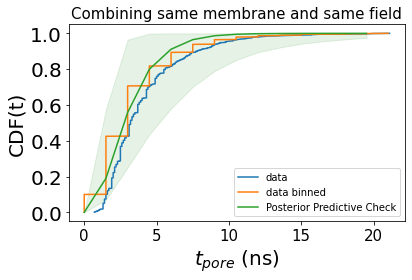

In [27]:
model_path = "../models/tpore_survival_analysis_same_membrane.nc"
trace = az.from_netcdf(model_path)
fig, ax = plot_ppc(
    trace,
    interval_length,
    "Combining same membrane and same field",
    "../reports/final_figures/ppc_same_membrane.svg",
)

/home/sperez/data_partition/bin2/anaconda3/envs/electroporation_modeling2/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


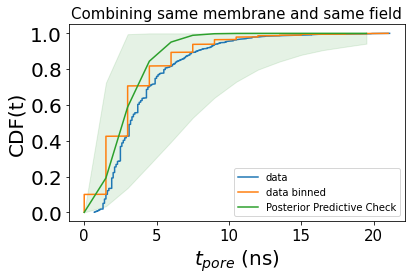

In [28]:
model_path = "../models/tpore_survival_analysis_individual_sim.nc"
trace = az.from_netcdf(model_path)
fig, ax = plot_ppc(
    trace,
    interval_length,
    "Combining same membrane and same field",
    "../reports/final_figures/ppc_individual_sim.svg",
)

/home/sperez/data_partition/bin2/anaconda3/envs/electroporation_modeling2/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


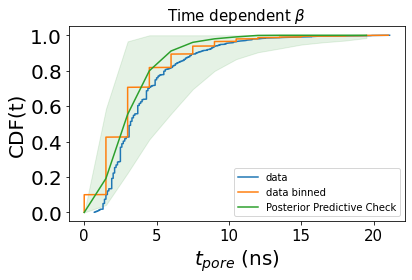

In [29]:
model_path = "../models/tpore_survival_analysis_time_dep_beta_same_membrane.nc"
trace = az.from_netcdf(model_path)
fig, ax = plot_ppc(
    trace,
    interval_length,
    r"Time dependent $\beta$",
    "../reports/final_figures/ppc_time_dependent_beta.svg",
    t_dep_beta=True,
)

## Posterior Beta Values

/home/sperez/data_partition/bin2/anaconda3/envs/electroporation_modeling2/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


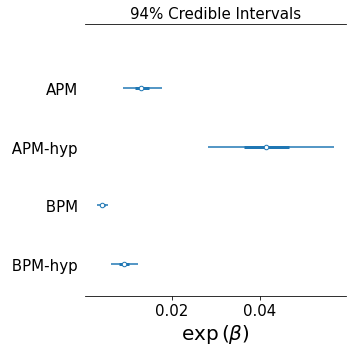

In [30]:
model_path = "../models/tpore_survival_analysis_same_membrane.nc"
trace = az.from_netcdf(model_path)
trace.posterior = trace.posterior.rename({"exp_beta": "expbeta"})
fig, ax = plot_posterior_exp_beta(
    trace, "../reports/final_figures/posterior_exp_beta_same_membrane.svg"
)

/home/sperez/data_partition/bin2/anaconda3/envs/electroporation_modeling2/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


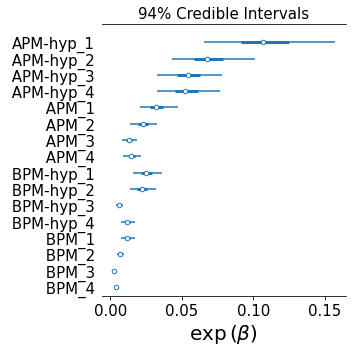

In [31]:
model_path = "../models/tpore_survival_analysis_individual_sim.nc"
trace = az.from_netcdf(model_path)
trace.posterior = trace.posterior.rename({"exp_beta": "expbeta"})

# If rendering with latex need to escape underscores.

# change_underscores = lambda s: s.replace("_", "\_")
# change_underscores = np.vectorize(change_underscores)
# trace = trace.assign_coords(
#    Membrane=change_underscores(trace.posterior.Membrane.values)
# )
fig, ax = plot_posterior_exp_beta(
    trace, "../reports/final_figures/posterior_exp_beta_individual_sim.svg"
)

## Plotting lambda posterior

/home/sperez/data_partition/bin2/anaconda3/envs/electroporation_modeling2/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


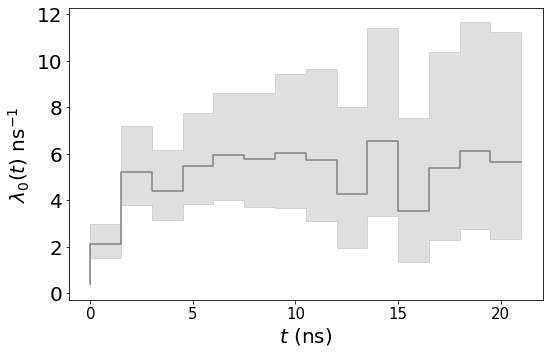

In [32]:
model_path = "../models/tpore_survival_analysis_same_membrane.nc"
trace = az.from_netcdf(model_path)
trace.posterior = trace.posterior.rename({"exp_beta": "expbeta"})
fig, ax = plot_posterior_lambda0(
    trace, "../reports/final_figures/posterior_lambda0_same_membrane.svg"
)

## Beta time dependence

/home/sperez/data_partition/bin2/anaconda3/envs/electroporation_modeling2/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


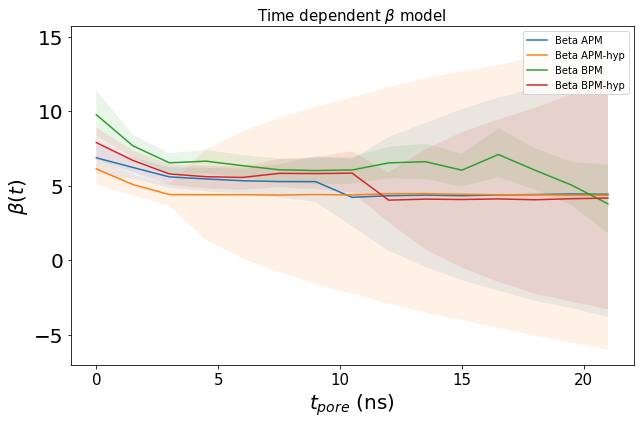

In [33]:
model_path = "../models/tpore_survival_analysis_time_dep_beta_same_membrane.nc"
trace = az.from_netcdf(model_path)
fig, ax = plot_posterior_beta_of_t(
    trace,
    category_dic,
    "../reports/final_figures/posterior_beta_of_t.svg",
)

## Histograms of poration times

/home/sperez/data_partition/bin2/anaconda3/envs/electroporation_modeling2/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


(<Figure size 648x432 with 1 Axes>,
 <AxesSubplot:xlabel='$t_{pore}$ (ns)', ylabel='$p(t_{pore})$'>)

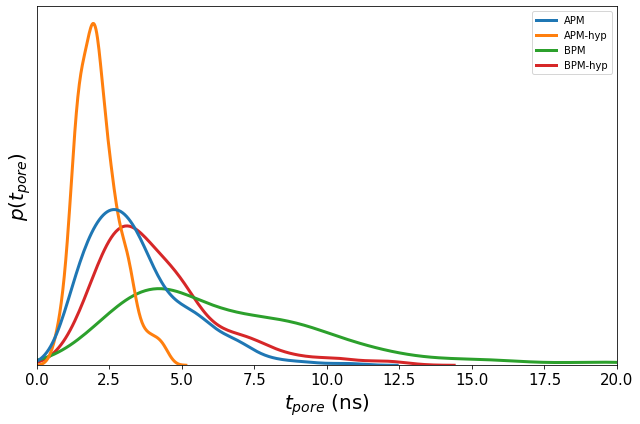

In [34]:
plot_kde_t_pore(df.copy(), "../reports/final_figures/t_pore_distribution.svg")